### Задача 3.1
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import requests

In [3]:
def metcalcnewdata(dop_path, osn_path, stud_path, check_path, metrix=None):
    'Функция считывает переданные по 4 параметрам датасеты и на основании параметров пересчитыватет метрики'
    try: df_dop = pd.read_csv(dop_path)
    except FileNotFoundError: return "Файл не найден"
    
    # Проверка структуры данных (если столбцов 2 и 1 из них целочисленного типа, другой - строкого, то
    # происходит переименование соот-но в 'id' и 'grp')
    if len(df_dop.columns) != 2 or df_dop.dtypes.nunique() != 2:
        return "Ошибка структуры данных"
    id_col = df_dop.select_dtypes(include=['int', 'int64']).columns.tolist()
    grp_col = df_dop.select_dtypes(include=['object']).columns.tolist()
    if len(id_col) != 1 or len(grp_col) != 1:
        return "Ошибка структуры данных"
    df_dop.rename(columns={id_col[0]: 'id', grp_col[0]: 'grp'}, inplace=True)
    
#     загрузка прочих данных
    try: groupdf = pd.read_csv(osn_path, sep = ';')
    except FileNotFoundError: return "Файл не найден"
    try: studdf = pd.read_csv(stud_path)
    except FileNotFoundError: return "Файл не найден"
    try: checkdf = pd.read_csv(check_path, sep = ';')
    except FileNotFoundError: return "Файл не найден"    
    
#     добавляем поля и соединяем данные о гр польз-лей
    df_dop['dop'] = 1
    groupdf['dop'] = 0
    df = groupdf.append(df_dop, ignore_index=True)
    df['grp_dig'] = df['grp'].apply(lambda x: 0 if x == 'A' else 1)
    
#     соединим с данными об активности и покупках польз-лей
    checkdf = checkdf.rename(columns={'student_id': 'pay_id'})
    t2 = studdf.merge(checkdf, how = 'left', left_on='student_id', right_on='pay_id')
    t2['rev'].fillna(0, inplace=True)
    df = df.merge(t2, how = 'left', left_on='id', right_on='student_id')
    df['active'] = df['student_id'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['is_check'] = df['pay_id'].apply(lambda x: 0 if pd.isna(x) else 1)
    df.rename(columns={'student_id': 'act_id'}, inplace=True)
    
#     считаем метрики только для основной части данных
    df_by_gr_base = df[df['dop'] == 0].groupby('grp', as_index = False). \
                    agg(grp_dig = ('grp_dig', 'mean'), 
                        stud_count = ('id', 'count'), 
                        CR_act = ('active', 'mean'), 
                        act_count = ('act_id', 'count'), 
                        CR_pay = ('is_check', 'mean'), 
                        pay_count = ('pay_id', 'count'),
                        rev_sum = ('rev', 'sum'))
    
#     считаем метрики на всех данных (с доп данными)
    df_by_gr = df.groupby('grp', as_index = False).agg(grp_dig = ('grp_dig', 'mean'), stud_count = ('id', 'count'), 
                                        CR_act = ('active', 'mean'), act_count = ('act_id', 'count'), 
                                        CR_pay = ('is_check', 'mean'), pay_count = ('pay_id', 'count'),
                                       rev_sum = ('rev', 'sum'))    
    
#     производные метрики считаем только если их надо выводить (в зависимости от параметров ф-ции)
    if metrix is None or 'CR_pay_act' in metrix: 
        df_by_gr_base['CR_pay_act'] = df_by_gr_base['pay_count'] / df_by_gr_base['act_count']
        df_by_gr['CR_pay_act'] = df_by_gr['pay_count'] / df_by_gr['act_count']
        
    if metrix is None or 'ARPU' in metrix:
        df_by_gr_base['ARPU'] = df_by_gr_base['rev_sum'] / df_by_gr_base['stud_count']
        df_by_gr['ARPU'] = df_by_gr['rev_sum'] / df_by_gr['stud_count']
    
    if metrix is None or 'ARPAU' in metrix:
        df_by_gr_base['ARPAU'] = df_by_gr_base['rev_sum'] / df_by_gr_base['act_count']
        df_by_gr['ARPAU'] = df_by_gr['rev_sum'] / df_by_gr['act_count']
        
    if metrix is None or 'ARPPU' in metrix:
        df_by_gr_base['ARPPU'] = df_by_gr_base['rev_sum'] / df_by_gr_base['pay_count']
        df_by_gr['ARPPU'] = df_by_gr['rev_sum'] / df_by_gr['pay_count']

    df_by_gr_base['data_type'] = 'base'
    df_by_gr['data_type'] = 'all'
    df_by_gr = df_by_gr_base.append(df_by_gr, ignore_index=True)
    
    if metrix is None:
        return df_by_gr
    else:
        col2show = ['grp', 'data_type'] + [col for col in metrix if col in df_by_gr.columns]
        return df_by_gr[col2show]

функция metcalcnewdata запускается с 4мя обязательными параметрами: 

dop_path - путь к дополнительному файлу с информацией о принадлежности пользователя к группам groups_add.csv

osn_path - путь к основному файлу с информацией о принадлежности пользователя к группам groups.csv

stud_path - путь к файлу с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента active_studs.csv

check_path - путь к файлу с информацией об оплатах пользователей в дни проведения эксперимента checks.csv

и одним необязательным:
metrix (по умолчанию не задан) - список (или кортеж или сет) с набором метрик например `['ARPAU', 'ARPU', 'ARPPU']`, если параметр не задан - выводятся все метрики, в противном случае - те, что указаны в параметре metrix. 

Перечень метрик:

'stud_count' - количество пользователей

'act_count' - количество активных пользователей

'pay_count' - количество пользователей, совершивших покупки

'rev_sum' - сумма платежей по группе

'CR_act' - конверсия пользователей в активных пользователей

'CR_pay' - конверсия пользователей в пользователей, совершивших покупки  

'CR_pay_act' - конверсия активных пользователей в пользователей, совершивших покупки 

'ARPU' - средний чек на пользователя

'ARPAU' - средний чек на активного пользователя

'ARPPU' - средний чек на пользователя, совершившего покупки

помимо метрик выводятся столбцы:

'grp' - принадлежность пользователя к группе тестирования

'data_type' - происхождение данных для обработки: полученны из основного файла (base) или полные, из основного и дополнительного (all)

### Задача 3.2
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [4]:
def metrix_graf(df = metcalcnewdata(dop_path, osn_path, stud_path, check_path), metrix=['stud_count']):
    '''Функция строит графики (барчарты) метрик, на основе датафрейма (1й параметр) и 
    указанных метрик (2й параметр в виде списка)'''
    plt.figure(figsize=(4, 6))
    for metric in metrix:
        plt.figure()
        ax = sns.barplot(x='grp', y=metric, hue='data_type', data=df, dodge=True)
        plt.legend(loc='lower right')
        for p in ax.patches: # подписи к барам
            por = '.0f' if metric.endswith('_count') else '.5f' if metric.startswith('CR_') else '.3f'
            ax.annotate(format(p.get_height(), por), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, -10), textcoords='offset points')    

функция metrix_graf запускается с двумя параметрами:

df - обязательный - датафрейм для обработки, формата выгружаемого функцией metcalcnewdata 

metrix - список (кортеж или сет) с набором метрик например `['ARPAU', 'ARPU', 'ARPPU']`, если параметр не задан - строится один график по метрике 'stud_count', в противном случае строятся графики по метрикам указанными в списке metrix.

Графики выводятся в виде барчарта: слева 2 барчарта по метрике для группы A (по основному файлу (base) и полным данным (all)), справа 2 барчарта по метрике для группы B

Список возможных метрик:

'stud_count' - количество пользователей

'act_count' - количество активных пользователей

'pay_count' - количество пользователей, совершивших покупки

'rev_sum' - сумма платежей по группе

'CR_act' - конверсия пользователей в активных пользователей

'CR_pay' - конверсия пользователей в пользователей, совершивших покупки  

'CR_pay_act' - конверсия активных пользователей в пользователей, совершивших покупки 

'ARPU' - средний чек на пользователя

'ARPAU' - средний чек на активного пользователя

'ARPPU' - средний чек на пользователя, совершившего покупки


#### примеры вызова функции metcalcnewdata:

In [6]:
# для загрузки с ЯД (иногда заканчивается лимит на скачивания):
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# dop_path = requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))).json()['href']
# osn_path = requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/UhyYx41rTt3clQ'))).json()['href']
# stud_path = requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))).json()['href']
# check_path = requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'))).json()['href']

# прямые ссылки:
dop_path = r'../projdata/Проект_2_group_add.csv'
osn_path = r'../projdata/Проект_2_groups.csv'
stud_path = r'../projdata/Проект_2_active_studs.csv'
check_path = r'../projdata/Проект_2_checks.csv'

# сами примеры:
# metcalcnewdata(dop_path, osn_path, stud_path, check_path, ['ARPAU', 'ARPU', 'ARPPU']) 
metrix = {'CR_act', 'CR_pay', 'ARPU', 'ARPAU', 'ARPPU'}
metcalcnewdata(dop_path, osn_path, stud_path, check_path, metrix)
# metcalcnewdata(dop_path, osn_path, stud_path, check_path)

,grp,data_type,CR_act,CR_pay,ARPPU,ARPAU,ARPU
0,A,base,0.104628,0.005317,933.589744,47.439739,4.963534
1,B,base,0.113571,0.005233,1255.827487,57.864567,6.571715
2,A,all,0.104676,0.005309,933.589744,47.347204,4.956102
3,B,all,0.113605,0.005244,1257.878992,58.058798,6.595762


#### примеры вызова функции metrix_graf:

<Figure size 288x432 with 0 Axes>

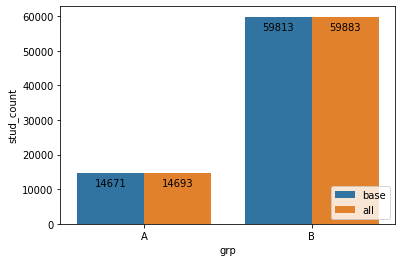

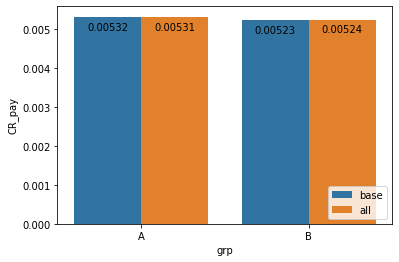

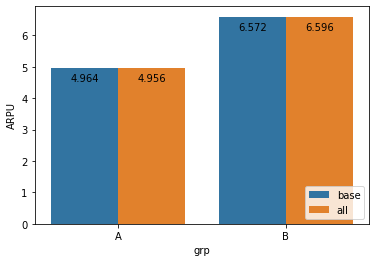

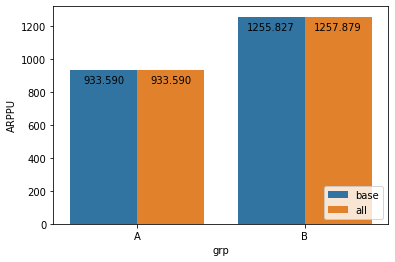

In [7]:
# для загрузки с ЯД (иногда заканчивается лимит на скачивания):
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# dop_path = requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))).json()['href']
# osn_path = requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/UhyYx41rTt3clQ'))).json()['href']
# stud_path = requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))).json()['href']
# check_path = requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'))).json()['href']

# прямые ссылки:
dop_path = r'../projdata/Проект_2_group_add.csv'
osn_path = r'../projdata/Проект_2_groups.csv'
stud_path = r'../projdata/Проект_2_active_studs.csv'
check_path = r'../projdata/Проект_2_checks.csv'

# сами примеры:
# metrix = ['ARPAU', 'ARPU', 'ARPU', 'ARPU', 'ARPPU']
# metrix_graf(metcalcnewdata(dop_path, osn_path, stud_path, check_path), metrix)
metrix_graf(metcalcnewdata(dop_path, osn_path, stud_path, check_path), ['stud_count', 'CR_pay', 'ARPU', 'ARPPU'])
# metrix_graf(metcalcnewdata(dop_path, osn_path, stud_path, check_path)) 
# metrix_graf()

В файле a-pitev-Prj_v2_task3-1.py в этой же ветке, приведена модифицированная функция metcalcnewdata (загрузка основных и дополнительных данных, объединение с дополнительными и пересчёт метрик) для автоматизированного запуска в Airflow. Т.к. в данном случаее, при автоматческом выполнении, не стоит задачи, чтобы данные функции были использованы как-то ещё (для вывода графиков например), то возврат датафрейма (как было сделано выше) был заменён на печать. Это сделано специально, чтобы в журнале было видно, какие значения выводит, но данные мы из нее никуда не передаём. Запуск функции настроен на вывод метрик CR_pay, ARPU, ARPPU, но можно конечно сделать иначе.

Можно убедится, что задание успешно отрабатывает (https://airflow-da.lab.karpov.courses/tree?dag_id=a_pitev_upload_nd_recalc)

In [17]:
help(metrix_graf)

Help on function metrix_graf in module __main__:

metrix_graf(df, metrix=['stud_count'])
    Функция строит графики (барчарты) метрик, на основе датафрейма (1й параметр) и 
    указанных метрик (2й параметр в виде списка)

